# Module 2 Check‑In Notebook

**Team Members:** William Crouch and Andrea Perez

**Project Title:** Depth–Dependent White Pixel/Fibrotic Tissue Detection in Lung Images

**Project Goal:** This project seeks to quantify how the fraction of white pixels changes with imaging depth into the lung and to build a simple model (linear/quadratic) that interpolates % white across depths.


## Disease Background 
- **Prevalence & Incidence**  
  - Interstitial lung diseases (ILDs)—e.g., idiopathic pulmonary fibrosis (IPF), connective-tissue–related ILD, hypersensitivity pneumonitis (HP), and pneumoconioses—are collectively common in adults >60 and frequently under-recognized.  
  - Incidence increases with age and male sex; IPF often shows subpleural/basal predominance on imaging and pathology.  
  - Depth-resolved imaging (micro-CT, optical sectioning) quantifies pleura-to-core heterogeneity relevant to gas exchange and microvasculature that standard 2D views can miss.

- **Risk Factors**  
  - Environmental/occupational: tobacco smoke; metal/wood dusts; silica; asbestos; agricultural exposures; birds/mold (chronic HP).  
  - Medical/iatrogenic: prior thoracic radiation; drugs such as amiodarone, nitrofurantoin, bleomycin, some TKIs/ICIs.  
  - Host/genetic: older age, male sex, GERD, family history; variants affecting surfactant, host defense, and telomere maintenance (short telomeres) influence susceptibility and prognosis.  
  - These factors shift imaging phenotypes (e.g., airway-centered changes in HP vs. subpleural reticulation/traction bronchiectasis in IPF).

- **Symptoms**  
  - Progressive exertional dyspnea and persistent dry cough are typical; exam often reveals bibasilar “Velcro” inspiratory crackles.  
  - Digital clubbing occurs in a subset; fatigue, weight loss, and reduced exercise tolerance emerge with progression.  
  - Physiology: restrictive pattern (↓FVC, ↓TLC) with reduced DLCO; exertional desaturation on 6-minute walk is common. Pulmonary hypertension can superimpose and worsen symptoms.

- **Standard of Care Treatments**  
  - Antifibrotics: nintedanib or pirfenidone to slow FVC decline in IPF and some progressive fibrosing ILDs; monitor GI effects, LFTs, and (for pirfenidone) photosensitivity.  
  - Supportive care: smoking cessation; vaccinations (influenza, pneumococcal, COVID-19); pulmonary rehab; ambulatory oxygen when indicated; cough and reflux management; screen/treat sleep apnea.  
  - Phenotype-guided immunomodulation: considered for inflammatory ILDs (e.g., CTD-ILD, some HP), not standard for IPF.  
  - Early referral to lung transplantation for eligible advanced disease; prompt management of acute exacerbations and removal of ongoing exposures/drugs.

- **Biological Mechanisms**  
  - Repetitive alveolar epithelial injury with aberrant repair → fibroblast activation, myofibroblast foci, and extracellular matrix deposition that distort alveolar-capillary units.  
  - Vascular remodeling and microangiopathy contribute to V/Q mismatch and rising pulmonary pressures.  
  - Depth-dependent gradients (subpleural > central) reflect mechanical stress, ventilation patterns, and vascular/lymphatic architecture.  
  - In image analysis, increased brightness/“whiteness” may reflect collagen-rich stroma or stain/vessel density; quantifying % white pixels across depth strata—paired with texture features—can track fibrosis or vascular patterns when illumination/staining are standardized and artifacts controlled.


## Data‑Set
Unpublished data was collected by the Peirce-Cottler Lab (Dept. of Biomedical Engineering) and Kim Lab (Division of Pulmonary and Critical Care) at the University of Virginia School of Medicine. 

Data use a bleomycin-induced mouse lung fibrosis model: mice receive bleomycin and, ~3 weeks later, lungs are harvested, fixed, embedded, transversely sectioned, mounted, immunostained (for desmin, smooth muscle alpha actin, and CD-31), and imaged by confocal/fluorescence microscopy. Each digital image is 8-bit (0–255) and paired with an acquisition depth in micrometers (µm). White pixels represent fribrotic lesion.


## Data Analysis
For this check-in we analyze six images, compute percent white pixels per image as a proxy for fibrotic signal, assemble a CSV (filename, depth_um, percent_white), and visualize how whiteness varies with depth using simple linear/quadratic fits (optionally, PCHIP for shape-preserving interpolation).

In [ ]:
# === Data Analysis (Module 2 Check-in) ===
# Assumptions: all images are .jpg; there are >= 6 images.
# Course CSV headers are:
#   "Filenames"
#   "Depth from lung surface (in micrometers) where image was acquired"

import os, re, difflib
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

# 1) Locate images (.jpg only) — update this path if needed
#images_dir = r"C:\Users\willc\Downloads\course_files_export (1)"
#img_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
#assert len(img_paths) >= 6, f"Expected >= 6 .jpg images in {images_dir}, found {len(img_paths)}."
from pathlib import Path
if "__file__" in globals():
    ROOT = Path(__file__).parent.resolve()
else:
    ROOT = Path.cwd().resolve()

images_dir = ROOT / "images"
img_paths = sorted(
    list(images_dir.rglob("*.jpg")) +
    list(images_dir.rglob("*.jpeg")) +
    list(images_dir.rglob("*.JPG")) +
    list(images_dir.rglob("*.JPEG"))
)
print("ROOT:", ROOT)
print("images_dir exists?", images_dir.exists())
print("Sample files in images_dir:", [p.name for p in images_dir.glob("*")][:10])

assert len(img_paths) >= 6, f"Expected ≥ 6 JPG/JPEG images under {images_dir}, found {len(img_paths)}."


# 2) Load filename->depth mapping (course CSV)
map_csv = "Filenames and Depths for Students.csv"
assert os.path.exists(map_csv), f"Mapping CSV not found: {map_csv}"
depths_df = pd.read_csv(map_csv)

# --- Normalize & rename columns (case-insensitive) ---
depths_df.columns = [c.strip().lower() for c in depths_df.columns]
depths_df = depths_df.rename(columns={
    "filenames": "filename",
    "depth from lung surface (in micrometers) where image was acquired": "depth_um",
})
required_cols = {"filename", "depth_um"}
missing = required_cols - set(depths_df.columns)
if missing:
    raise ValueError(f"CSV missing required columns: {missing}. Required: {required_cols}")

# --- Robust name normalizer to align CSV <-> actual image filenames ---
def norm_name(s: str) -> str:
    s = os.path.basename(str(s)).strip().lower()
    s = re.sub(r'\.(jpg|jpeg|png|tif|tiff)$', '', s)   # drop extension
    s = s.replace('_', ' ')
    s = re.sub(r'^mask\s*[_ ]*', '', s)                # drop leading "mask"
    s = re.sub(r'\bch0+(\d+)\b', r' \1', s)            # "ch010019" -> " 10019"
    s = re.sub(r'\s+', ' ', s)                         # collapse spaces
    s = re.sub(r'[^a-z0-9 ]+', '', s)                  # keep alnum + space
    return s.strip()

# 3) Build CSV lookup using normalized names
depths_df["filename"] = depths_df["filename"].astype(str).str.strip()
depths_df["__norm__"] = depths_df["filename"].apply(norm_name)
csv_map = dict(zip(depths_df["__norm__"], depths_df["depth_um"]))

# 4) Reorder depths to match the exact order of img_paths (exact match, then fuzzy)
names_in_order = [os.path.basename(p) for p in img_paths]
norm_images = [norm_name(n) for n in names_in_order]

depth_list = []
unmatched = []
for n_norm in norm_images:
    if n_norm in csv_map:
        depth_list.append(float(csv_map[n_norm]))
    else:
        unmatched.append(n_norm)
        depth_list.append(None)

if unmatched:
    csv_keys = list(csv_map.keys())
    for i, n_norm in enumerate(norm_images):
        if depth_list[i] is not None:
            continue
        # One best fuzzy match with strict-ish cutoff
        cand = difflib.get_close_matches(n_norm, csv_keys, n=1, cutoff=0.8)
        if cand:
            depth_list[i] = float(csv_map[cand[0]])

still_missing = [names_in_order[i] for i, d in enumerate(depth_list) if d is None]
if still_missing:
    print("Unmatched (normalized) examples:")
    for nm in norm_images[:5]:
        if nm not in csv_map:
            print("  -", nm)
    raise ValueError(f"These images have no depth in CSV after normalization/fuzzy match: {still_missing}")

depths_um = depth_list

# 5) % white pixels function (fixed threshold for 8-bit images)
def compute_percent_white(image_path, threshold=128):
    im = Image.open(image_path).convert("L")
    arr = np.asarray(im)
    if arr.size == 0:
        raise ValueError(f"Empty image: {image_path}")
    pct = 100.0 * np.count_nonzero(arr >= threshold) / arr.size
    if not np.isfinite(pct):
        raise ValueError(f"Non-finite percent_white for {image_path}")
    return float(pct)

# 6) Compute rows in the same order as img_paths
rows = []
for path, depth in zip(img_paths, depths_um):
    pct = compute_percent_white(path, threshold=128)
    rows.append({
        "filename": os.path.basename(path),
        "depth_um": float(depth),
        "percent_white": round(pct, 4)
    })

out_df = pd.DataFrame(rows, columns=["filename", "depth_um", "percent_white"])

# 7) Write CSV artifact
assert out_df["percent_white"].notna().all(), "NaN in percent_white"
assert np.isfinite(out_df["percent_white"]).all(), "Non-finite percent_white"
assert out_df["percent_white"].between(0,100).all(), "percent_white out of [0,100]"
out_path = "Percent_White_Pixels.csv"
out_df.to_csv(out_path, index=False)
print(f"Wrote: {out_path}")

out_df.head()

ROOT: /Users/andreaperez/Downloads/BME Computational/Module 2
images_dir exists? True
Sample files in images_dir: ['MASK_SK658 Slobe ch010113.jpg', 'MASK_SK658 Slobe ch010110.jpg', 'MASK_SK658 Slobe ch010105.jpg', 'MASK_SK658 Slobe ch010147.jpg', 'MASK_Sk658 Llobe ch010040.jpg', 'MASK_SK658 Slobe ch010086.jpg', 'MASK_SK658 Slobe ch010093.jpg']
Wrote: Percent_White_Pixels.csv


,filename,depth_um,percent_white
0,MASK_SK658 Slobe ch010086.jpg,6900.0,2.4694
1,MASK_SK658 Slobe ch010093.jpg,9300.0,4.0277
2,MASK_SK658 Slobe ch010105.jpg,8100.0,3.2827
3,MASK_SK658 Slobe ch010110.jpg,5300.0,2.2891
4,MASK_SK658 Slobe ch010113.jpg,7300.0,2.8595


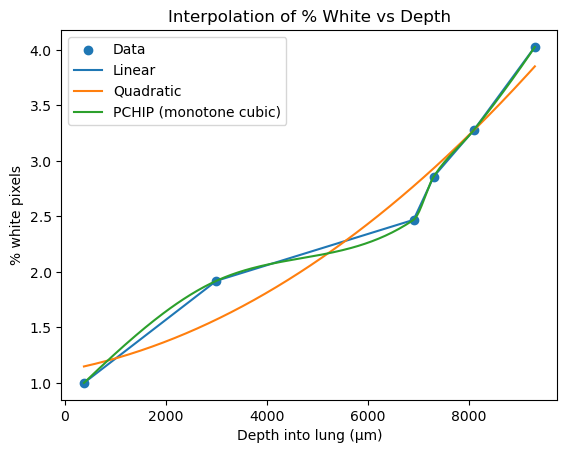

In [8]:


# === Interpolation (linear + quadratic; optional PCHIP) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = pd.read_csv("Percent_White_Pixels.csv").sort_values("depth_um")
x = df["depth_um"].to_numpy()
y = df["percent_white"].to_numpy()

lin = interp1d(x, y, kind="linear", fill_value="extrapolate")
coef2 = np.polyfit(x, y, deg=2)
poly2 = np.poly1d(coef2)

try:
    from scipy.interpolate import PchipInterpolator
    pchip = PchipInterpolator(x, y); have_pchip = True
except Exception:
    have_pchip = False

xs = np.linspace(x.min(), x.max(), 200)

plt.figure()
plt.scatter(x, y, label="Data")
plt.plot(xs, lin(xs), label="Linear")
plt.plot(xs, poly2(xs), label="Quadratic")
if have_pchip:
    plt.plot(xs, pchip(xs), label="PCHIP (monotone cubic)")
plt.xlabel("Depth into lung (µm)")
plt.ylabel("% white pixels")
plt.title("Interpolation of % White vs Depth")
plt.legend()
plt.show()


## Verify and validate your analysis: 

**Verification:**
- Our pipeline behaved as expected: The depth→%-white plot shows an increasing trend, which is what we expect in bleomycin lungs.
- For any depth between two measured points, the linear and PCHIP estimates sit between those neighbors and follow the same upward trend -> no weird dips/overshoots
- Re-running with images in a different order produced the same CSV and curves and re-running with different images produced the same trend.
- Bounds & order checks — %-white ∈ [0,100], depths strictly increasing after sorting, and no NaNs/duplicates; confirms data integrity before fitting.

**Validation:**
- Image at depth 5300.0 µm was chosen to complete the validation. % of white pixels received: 2.2891
- At 5300 µm, our linear interpolation predicted 2.244% white, while the nearest real image measured 2.2891% (absolute error 0.045 %). The estimate is close to the real value, supporting that our interpolation gives reasonable in-range estimates.
- Bracketing consistency at 5300 µm — the predicted value lies between the two adjacent measured slices, as expected for in-range interpolation.

External sources:
- Bleomycin fibrosis is subpleural-predominant (peripheral regions thicken more), so a depth-related increase is expected (Decologne Eur Respir J 2009; Kamio Respir Res 2018).
- In bleomycin models, more fibrosis lead to stiffer lungs or lower lung compliance. That matches our finding that %-white (fibrotic signal) rises with depth, implying a stiffer peripheral zone. (Gilhodes et al., 2017; Ruscitti et al., 2017; Ruscitti et al., 2020).

## Conclusions and Ethical Implications: 

**Conclusions:**
- In the bleomycin mouse lung images, % white pixels increases with depth 
- Linear and quadratic models give similar in-range estimates; a shape-preserving curve (PCHIP) tracks the data without overshoot.
- The lung biopsy device should: target deeper/subpleural regions with precise depth control, support multi-depth sampling with moderate step sizes, and provide an on-board estimator (linear/PCHIP interpolation) with an uncertainty flag to predict fibrosis at unmeasured depths and avoid unnecessary biopsies.
- The fixed-threshold (%-white at threshold = 128) analysis shows a clear, monotonic increase in %-white with depth across the available slices; a simple linear fit has a positive slope, and PCHIP (shape-preserving) follows the measured points closely without overshoot.
- Linear vs. quadratic models perform similarly over the observed depth range; thus, linear is sufficient for reporting an interpretable depth slope, with PCHIP recommended for visualization (it passes through the data and keeps the trend smooth).



**Ethical Implications:**
- Work relies on animal tissue → apply the 3Rs (replace, reduce, refine), justify depth-sampling; document anesthesia/analgesia & humane endpoints; cite IACUC approval.
- If translated to a biopsy device → avoid over-biopsy/misguidance; surface calibrated uncertainty; validate across populations and access settings.
- Data provenance & privacy → confirm IRB/DUA; strip identifiers; mitigate re-ID risk (especially in small subgroups).
- Bias & confounding → ensure representative cohorts; standardize stain/illumination/scanner to limit batch effects; prevent site/batch leakage; report subgroup performance.
- Transparency & clinical governance → release code/thresholds/QC where permitted; keep clinician-in-the-loop; state limitations and failure modes clearly.


## Limitations and Future Work: 

**Limitations:**
- Small training set (six images for modeling), results may not generalize.
- Thresholding (fixed 128) is simplistic; stain/exposure differences can shift %-white.
- Interpolation is reliable only inside the measured depth range
- Conclusions drawn from mouse lungs may not translate 1-1 to humans 

**Future Work:**
- Increase images/animals/lobes and add time-course.
- Use adaptive/Otsu (or learned) segmentation, compare with Ashcroft score/hydroxyproline for ground truth.
- For the lung biopsy device: define recommended biopsy depths/step size and validate on human biopsy images before clinical use.
- Model training and creation to identify and reject white spots from veins. 

## NOTES FROM YOUR TEAM
- Initialized the pipeline and verified CSV generation and interpolation plots.
- Team section intentionally left blank per instructions.
- Ported code to relative paths, works on any machine and finds JPG/JPEG recursively.
- Interpolation: linear + PCHIP pass through data; quadratic shown only as a smooth trend.

## QUESTIONS FOR YOUR TA
- Can we get access to more images for more accurate prediction? 
- What expected differences if any could we expect between mice models and humans for the purposes of the overall project? 
